In [37]:
# from google.colab import files
# files.upload()


In [38]:
# from google.colab import drive
# drive.mount('/content/drive')

In [39]:
# !unzip -q /content/drive/MyDrive/chest_xray.zip -d /content/


In [40]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import os

In [41]:
data_dir="/kaggle/input/chest-xray-pneumonia/chest_xray"

train_dir=os.path.join(data_dir,"train")
val_dir=os.path.join(data_dir,"val")
test_dir=os.path.join(data_dir,"test")

In [42]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image

In [43]:
class ApplyCLAHE(object):
  def __init__(self,clip_limit=2.0,tile_grid_size=(8,8)):
    self.clip_limit=clip_limit
    self.tile_grid_size=tile_grid_size

  def __call__(self,img):
    img_array=np.array(img)
    clahe = cv2.createCLAHE(
            clipLimit=self.clip_limit,
            tileGridSize=self.tile_grid_size
        )
    if len(img_array.shape)==3:
      lab=cv2.cvtColor(img_array,cv2.COLOR_RGB2LAB)
      l,a,b=cv2.split(lab)
      cl=clahe.apply(l)
      limg=cv2.merge((cl,a,b))
      final_img=cv2.cvtColor(limg,cv2.COLOR_LAB2RGB)
    else:
      final_img=clahe.apply(img_array)

    return Image.fromarray(final_img)


In [44]:
data_transforms={
    "train":transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.CenterCrop(184),
        # ApplyCLAHE(clip_limit=2.0),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ]),
    "val_test":transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.CenterCrop(184),
        # ApplyCLAHE(clip_limit=2.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}

In [45]:
image_datasets={
    "train":datasets.ImageFolder(train_dir,data_transforms["train"]),
    "val":datasets.ImageFolder(val_dir,data_transforms["val_test"]),
    "test":datasets.ImageFolder(test_dir,data_transforms["val_test"])
}

In [46]:
batch_size=32

In [47]:
import torch
from torch.utils.data import WeightedRandomSampler


num_normal = 1341  # 1341
num_pneumonia = 3875  # 3875

class_weights = [1.0/num_normal, 1.0/num_pneumonia]
train_labels = image_datasets['train'].targets
sample_weights = [class_weights[label] for label in train_labels]
sample_weights = torch.DoubleTensor(sample_weights)
sampler = WeightedRandomSampler(
    weights=sample_weights, 
    num_samples=len(sample_weights), 
    replacement=True
)


In [48]:
dataloaders={
    "train":DataLoader(image_datasets["train"],batch_size=batch_size,sampler=sampler,shuffle=False),
    "val":DataLoader(image_datasets["val"],batch_size=batch_size,shuffle=False),
    "test":DataLoader(image_datasets["test"],batch_size=batch_size,shuffle=False)
}
class_names=image_datasets['train'].classes
print(f"Detected Classes: {class_names}")
print(f"Training images: {len(image_datasets['train'])}")

Detected Classes: ['NORMAL', 'PNEUMONIA']
Training images: 5216


In [49]:
dataloaders["train"]

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class BaselineCNN(nn.Module):
  def __init__(self,num_classes):
    super(BaselineCNN,self).__init__()
    self.block1=self._make_block(3,32)
    self.block2=self._make_block(32,64)
    self.block3=self._make_block(64,128)
    self.block4=self._make_block(128,256)
    self.gap = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.7), # Helps prevent overfitting
            nn.Linear(128, num_classes)
        )
  def _make_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
  def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_baseline = BaselineCNN(num_classes=1).to(device)



In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from collections import Counter

train_labels = image_datasets['train'].targets
counts = Counter(train_labels)

neg_count = counts[0]
pos_count = counts[1]

pos_weight_val = neg_count / pos_count

print(f"Dataset Balance - Normal: {neg_count}, Pneumonia: {pos_count}")
print(f"Applying Positive Weight: {pos_weight_val:.2f}")


Dataset Balance - Normal: 1341, Pneumonia: 3875
Applying Positive Weight: 0.35


In [55]:
import torch.optim as optim

In [ ]:
pos_weight = torch.tensor([1.2]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


In [ ]:
import torch.optim as optim

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',    # 'min' because we want to reduce LR when loss stops falling
    factor=0.1,    # multiply LR by 0.1 (e.g., 0.001 -> 0.0001)
    patience=6,    # how many epochs to wait before dropping LR
)

In [58]:
criterion

BCEWithLogitsLoss()

In [59]:
from sklearn.metrics import recall_score,f1_score,roc_auc_score
import numpy as np

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score

def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': [],
        'train_auc': [], 'val_auc': []
    }

    best_val_loss = float('inf')
    patience = 3
    counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            all_labels, all_preds, all_probs = [], [], []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    probs = torch.sigmoid(outputs)
                    preds = (probs > 0.6).float()

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.detach().cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            acc = accuracy_score(all_labels, all_preds)
            recall = recall_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds)
            auc = roc_auc_score(all_labels, all_probs)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(acc)
            history[f'{phase}_recall'].append(recall)
            history[f'{phase}_f1'].append(f1)
            history[f'{phase}_auc'].append(auc)

            print(
                f'{phase.upper()} Loss: {epoch_loss:.4f} | '
                f'Acc: {acc:.4f} | Recall: {recall:.4f} | '
                f'F1: {f1:.4f} | AUC: {auc:.4f}'
            )

            # # ---- Early stopping (VAL ONLY) ----
            # if phase == "val":
            #     scheduler.step(epoch_loss)
            #     if epoch_loss < best_val_loss:
            #         best_val_loss = epoch_loss
            #         torch.save(model.state_dict(), 'best_baseline_model.pth')
            #         counter = 0
            #     else:
            #         counter += 1
            #         if counter >= patience:
            #             print("Early stopping triggered!")
            #             return history

    return history


In [84]:
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import torch.optim as optim

In [ ]:

optimizer = optim.Adam(model_baseline.parameters(), lr=0.001,weight_decay=1e-5)

In [87]:
# START TRAINING
history = train_model(
    model=model_baseline,
    criterion=criterion,
    optimizer=optimizer,
    dataloaders=dataloaders,
    num_epochs=20
)

Epoch 1/20
TRAIN Loss: 0.2471 | Acc: 0.9170 | Recall: 0.8942 | F1: 0.9167 | AUC: 0.9670
VAL Loss: 0.6623 | Acc: 0.6250 | Recall: 0.5000 | F1: 0.5714 | AUC: 0.7656
Epoch 2/20
TRAIN Loss: 0.2403 | Acc: 0.9124 | Recall: 0.8938 | F1: 0.9119 | AUC: 0.9703
VAL Loss: 1.2690 | Acc: 0.6875 | Recall: 1.0000 | F1: 0.7619 | AUC: 0.8438
Epoch 3/20
TRAIN Loss: 0.2248 | Acc: 0.9283 | Recall: 0.9053 | F1: 0.9274 | AUC: 0.9732
VAL Loss: 0.7952 | Acc: 0.6875 | Recall: 0.8750 | F1: 0.7368 | AUC: 0.7812
Epoch 4/20
TRAIN Loss: 0.2338 | Acc: 0.9193 | Recall: 0.9028 | F1: 0.9184 | AUC: 0.9720
VAL Loss: 1.1552 | Acc: 0.6250 | Recall: 1.0000 | F1: 0.7273 | AUC: 0.8906
Epoch 5/20
TRAIN Loss: 0.2033 | Acc: 0.9325 | Recall: 0.9117 | F1: 0.9315 | AUC: 0.9786
VAL Loss: 0.6881 | Acc: 0.6875 | Recall: 0.8750 | F1: 0.7368 | AUC: 0.8594
Epoch 6/20
TRAIN Loss: 0.2106 | Acc: 0.9273 | Recall: 0.9083 | F1: 0.9267 | AUC: 0.9768
VAL Loss: 1.6474 | Acc: 0.5625 | Recall: 1.0000 | F1: 0.6957 | AUC: 0.9375
Epoch 7/20
TRAIN Loss:

In [88]:
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

Analyzing Training Dataset...
Training Accuracy: 0.9532


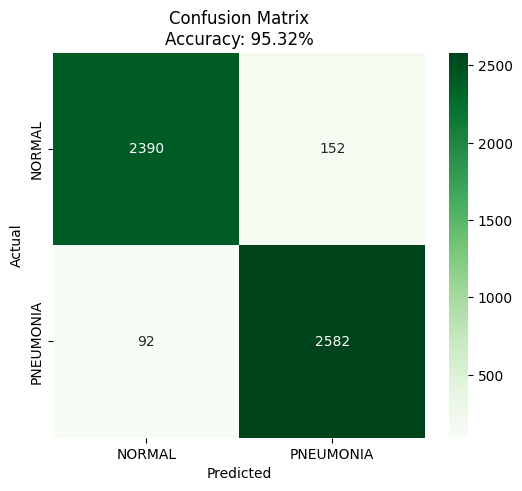

In [89]:
def plot_training_confusion_matrix(model, loader, class_names=['NORMAL', 'PNEUMONIA']):
    model.eval() # Ensure model is in eval mode
    y_true = []
    y_pred = []

    print("Analyzing Training Dataset...")
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # Convert model outputs to binary predictions
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate Accuracy
    train_acc = accuracy_score(y_true, y_pred)
    print(f"Training Accuracy: {train_acc:.4f}")

    # Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plotting
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', # Using Green for training
                xticklabels=class_names, yticklabels=class_names)

    plt.title(f'Confusion Matrix\nAccuracy: {train_acc:.2%}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('train_confusion_matrix.png')
    plt.show()

# Run for the training set
plot_training_confusion_matrix(model_baseline, dataloaders['train'])

Analyzing Training Dataset...
Training Accuracy: 0.8526


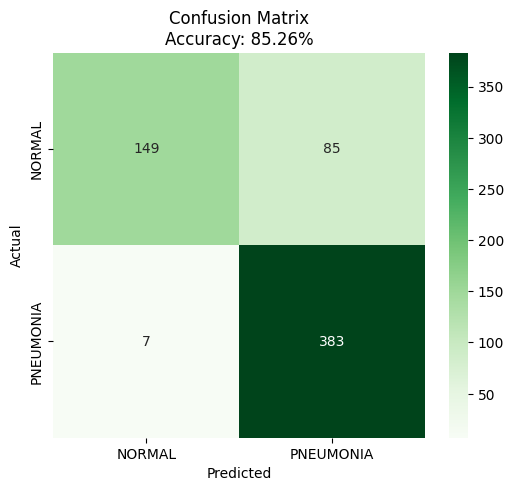

In [90]:
plot_training_confusion_matrix(model_baseline, dataloaders['test'])

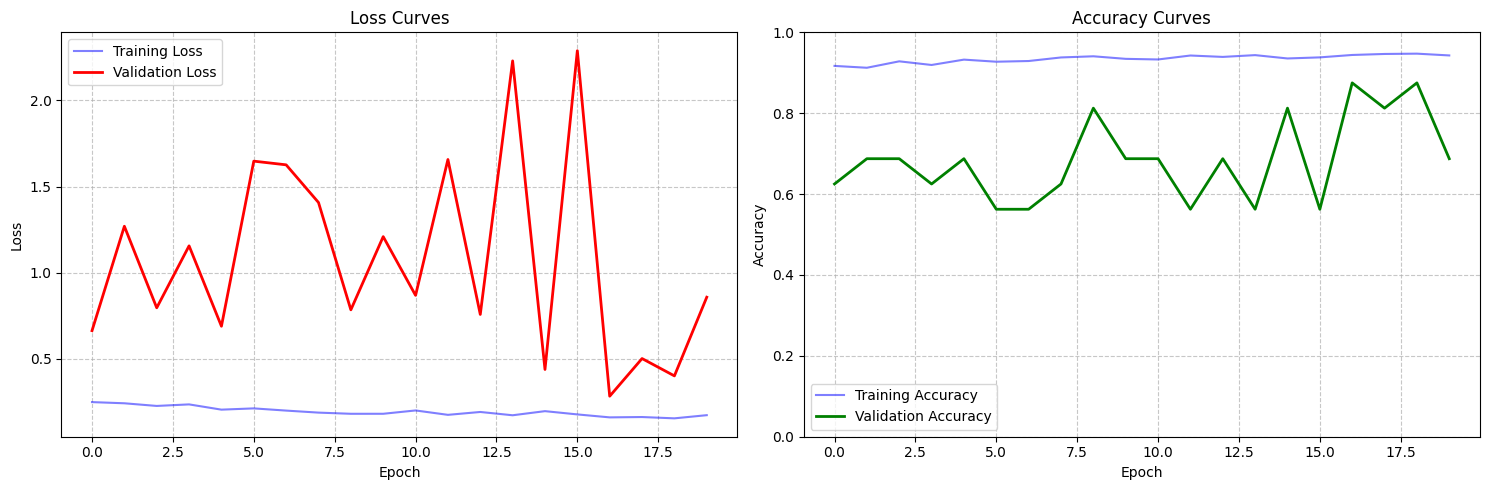

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='blue', alpha=0.5)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='red', linewidth=2)
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy', color='blue', alpha=0.5)
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', color='green', linewidth=2)
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.0]) # Set scale to 0-1 as in your screenshot
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_results(history)

Generating predictions on test set...


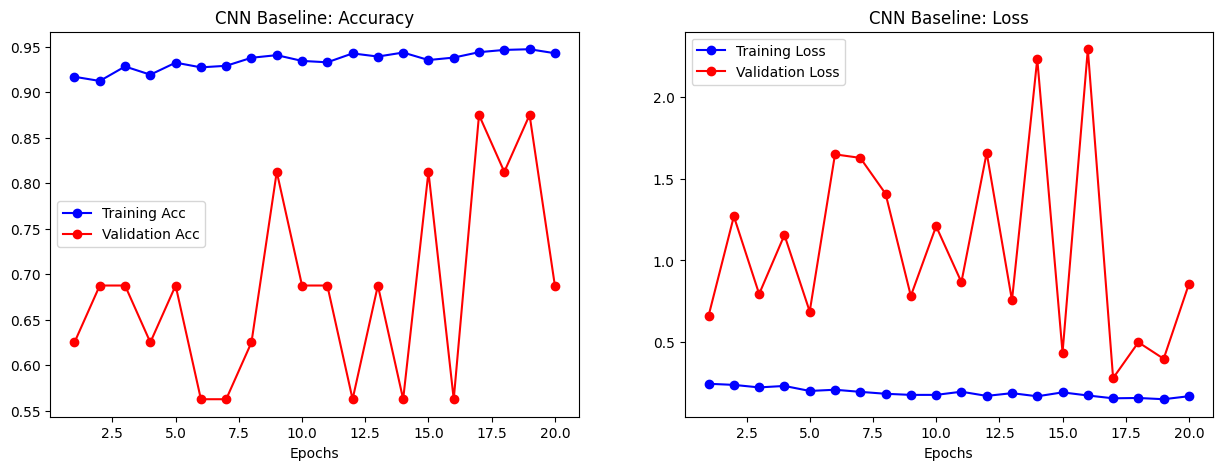

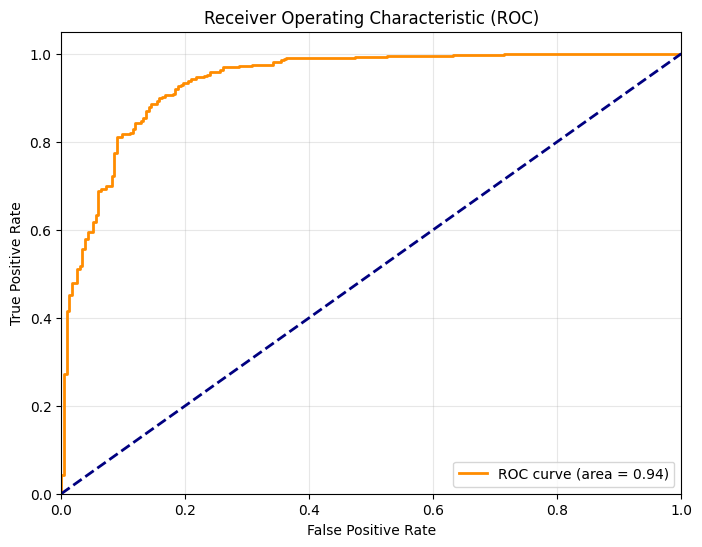

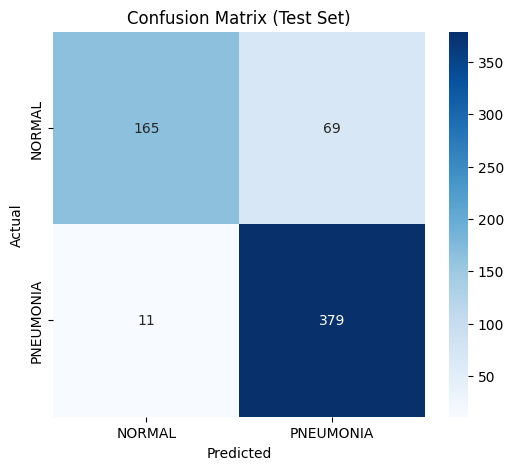

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix


y_true = []
y_probs = []
y_pred = []

model_baseline.eval()
print("Generating predictions on test set...")
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model_baseline(inputs)
        
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.6).float() 
        
        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy().flatten())
        y_pred.extend(preds.cpu().numpy().flatten())

resnet_results = {'y_true': y_true, 'y_probs': y_probs}


def plot_learning_curves(history, model_name="CNN Baseline"):
    epochs = range(1, len(history['train_acc']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    ax1.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    ax1.set_title(f'{model_name}: Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()
    
    ax2.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    ax2.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    ax2.set_title(f'{model_name}: Loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()
    plt.show()

def plot_roc_curves(results):
    fpr, tpr, _ = roc_curve(results['y_true'], results['y_probs'])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

def plot_final_confusion_matrix(y_true, y_pred, class_names=['NORMAL', 'PNEUMONIA']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Test Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_learning_curves(history)
plot_roc_curves(resnet_results)
plot_final_confusion_matrix(y_true, y_pred)

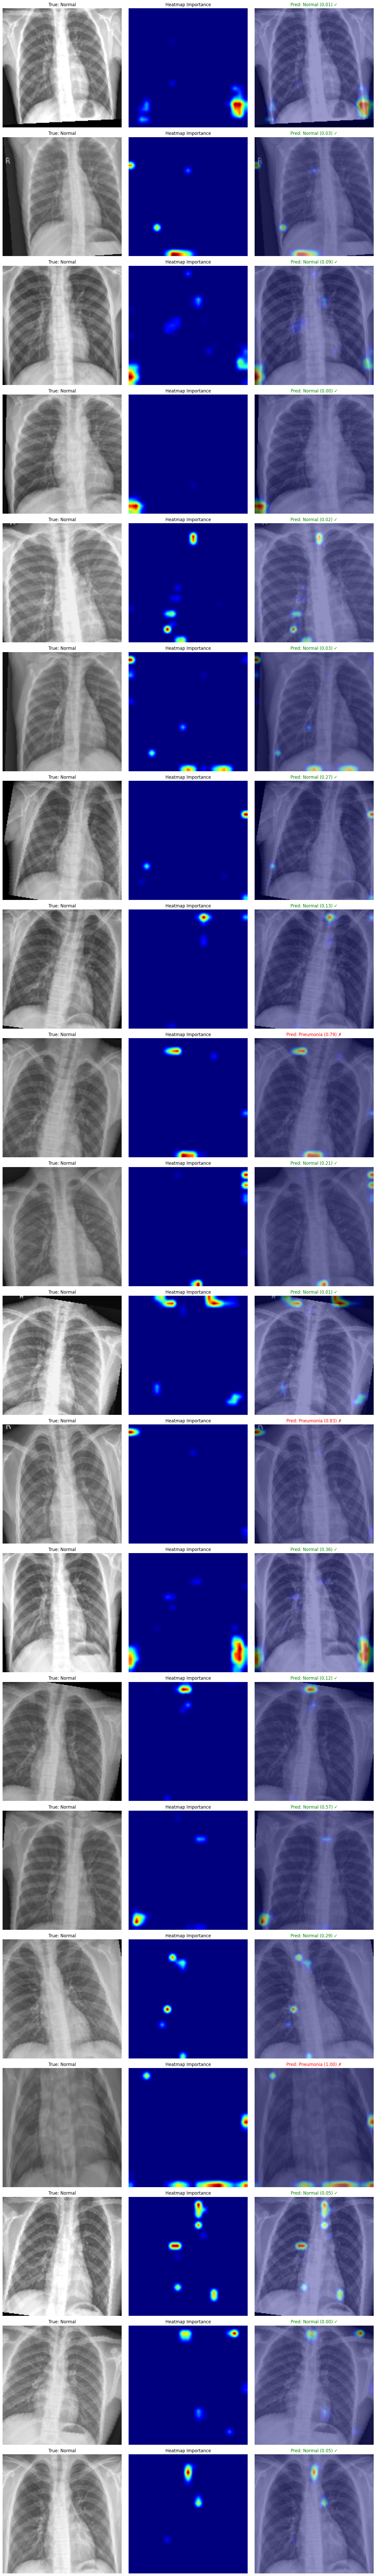

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        self.hooks = [
            target_layer.register_forward_hook(self._save_activation),
            target_layer.register_full_backward_hook(self._save_gradient)
        ]

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_image):
        self.model.zero_grad()
        
        output = self.model(input_image)
      
        output.backward(retain_graph=True)

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        cam = torch.sum(weights * self.activations, dim=1).squeeze()

        cam = F.relu(cam)

        cam_min, cam_max = cam.min(), cam.max()
        if cam_max > cam_min:
            cam = (cam - cam_min) / (cam_max - cam_min)
            
        return cam.detach().cpu().numpy()

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()


def visualize_gradcam(model, dataloader, num_images=5, device="cpu", class_names=['Normal', 'Pneumonia']):
    model.eval()
    

    target_layer = model.block4[0] 
    grad_cam = GradCAM(model, target_layer)

    images, labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    for idx in range(min(num_images, len(images))):
        img_tensor = images[idx].unsqueeze(0).to(device)
        true_label = int(labels[idx].item())

        with torch.no_grad():
            output = model(img_tensor)
            prob = torch.sigmoid(output).item()
            pred_label = 1 if prob > 0.6 else 0 

        heatmap = grad_cam.generate_heatmap(img_tensor)

        img_np = images[idx].permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(std * img_np + mean, 0, 1).astype(np.float32)

        heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
        heatmap_uint8 = np.uint8(255 * heatmap_resized)
        
        heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
        heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        
    
        superimposed = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)

  
        is_correct = "✓" if pred_label == true_label else "✗"
        text_color = 'green' if pred_label == true_label else 'red'

        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title(f"True: {class_names[true_label]}")
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(heatmap_resized, cmap='jet')
        axes[idx, 1].set_title("Heatmap Importance")
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(superimposed)
        axes[idx, 2].set_title(f"Pred: {class_names[pred_label]} ({prob:.2f}) {is_correct}", color=text_color)
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()
    
    grad_cam.remove_hooks()


model_baseline.to(device)

my_class_names = ['Normal', 'Pneumonia'] 

visualize_gradcam(
    model=model_baseline, 
    dataloader=dataloaders['test'], 
    num_images=20, 
    device=device,
    class_names=my_class_names
)

In [ ]:
visualize_gradcam(
    model=model_baseline, 
    dataloader=dataloaders['val'], 
    num_images=18, 
    device=device,
    class_names=my_class_names
)